In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [5]:
# Error indice
indice_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [6]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indice_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [8]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [9]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all_100206*1e-3)

In [10]:
normalized_scan_100206_full = scan_100206_long_no_background / S0_100206

In [11]:
normalized_scan_100206_full.shape

(935442, 288)

In [12]:
rand_half_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 9))

In [13]:
rand_half_bval_indice_100206

array([ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
       270, 271])

In [14]:
bvals_100206_half = bvals_all_100206[rand_half_bval_indice_100206]*1e-3

In [15]:
normalized_scan_100206_half = normalized_scan_100206_full[:, rand_half_bval_indice_100206]

In [16]:
big_b_indice_100206_half = np.where(bvals_100206_half != 0.005)[0]

In [17]:
big_b_indice_100206_half

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144])

In [18]:
bvals_100206_half_no_b5 = bvals_100206_half[big_b_indice_100206_half]

In [19]:
normalized_scan_100206_half_no_b5 = normalized_scan_100206_half[:, big_b_indice_100206_half]

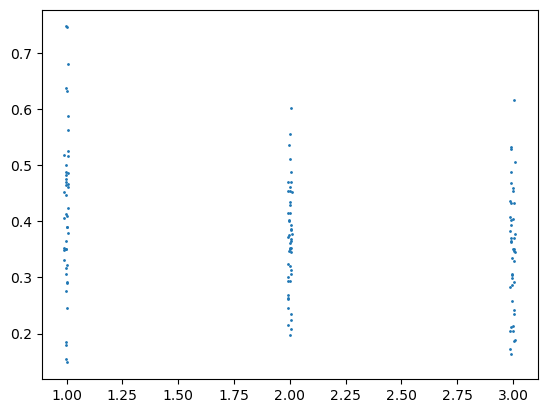

In [20]:
plt.plot(bvals_100206_half_no_b5, normalized_scan_100206_half_no_b5[42,:], "o", markersize = 1)

ANN

In [21]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [22]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [23]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [24]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206_half = n_100206_all[:, rand_half_bval_indice_100206]

In [25]:
print(n_100206_half.shape)
print(big_b_indice_100206_half)

(3, 145)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144]


In [26]:
n_100206_half_no_b5 = n_100206_half[:,big_b_indice_100206_half].T
print(n_100206_half_no_b5.shape)

b_values_100206_half_no_b5 = torch.FloatTensor(bvals_100206_half_no_b5)
gradient_directions_100206_half_no_b5 = torch.FloatTensor(n_100206_half_no_b5)

net = BallStickNet(gradient_directions_100206_half_no_b5, b_values_100206_half_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(136, 3)


In [27]:
batch_size = 128
num_batches = len(normalized_scan_100206_half_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_half_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [28]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.72it/s]


Loss: 530.476214019116
Average Loss: 0.07258842556364478
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.61it/s]


Loss: 422.1199969155714
Average Loss: 0.0577613569944679
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.22it/s]


Loss: 418.61181901814416
Average Loss: 0.0572813107578194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.97it/s]


Loss: 417.2390007846989
Average Loss: 0.05709345933014489
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.38it/s]


Loss: 417.03201323747635
Average Loss: 0.05706513591098472
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.26it/s]


Loss: 416.54168822802603
Average Loss: 0.05699804162945074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.36it/s]


Loss: 415.5644356585108
Average Loss: 0.0568643179609347
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.29it/s]


Loss: 415.14166872389615
Average Loss: 0.056806468079350865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.67it/s]


Loss: 414.8754866051022
Average Loss: 0.05677004469144803
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.30it/s]


Loss: 415.0503016056027
Average Loss: 0.056793965736946186
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  2%|██▋                                                                                                                                                           | 126/7308 [00:03<01:04, 111.44it/s]

X_batch: 
torch.Size([128, 136])
tensor([[0.4033, 0.2709, 0.1350,  ..., 0.4484, 0.1481, 0.2264],
        [0.4249, 0.2471, 0.1394,  ..., 0.4078, 0.1710, 0.2171],
        [0.4364, 0.2474, 0.0743,  ..., 0.4344, 0.1400, 0.2021],
        ...,
        [0.2096, 0.0854, 0.1585,  ..., 0.3641, 0.1957, 0.3355],
        [0.2698, 0.1470, 0.0990,  ..., 0.2234, 0.0785, 0.1291],
        [0.3940, 0.2310, 0.1536,  ..., 0.4423, 0.1918, 0.2660]])
X_pred: 
torch.Size([128, 136])
tensor([[0.3863, 0.2034, 0.1201,  ..., 0.3778, 0.1338, 0.1946],
        [0.4145, 0.2085, 0.1140,  ..., 0.4069, 0.1247, 0.2013],
        [0.4367, 0.2145, 0.1108,  ..., 0.4305, 0.1185, 0.2093],
        ...,
        [0.2648, 0.1916, 0.1433,  ..., 0.2538, 0.1640, 0.1783],
        [0.2523, 0.1183, 0.0744,  ..., 0.2454, 0.0842, 0.1119],
        [0.4099, 0.2447, 0.1572,  ..., 0.3991, 0.1768, 0.2321]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.21it/s]


Loss: 414.53565701050684
Average Loss: 0.05672354365223137
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.27it/s]


Loss: 413.9267895910889
Average Loss: 0.056640228460740134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.22it/s]


Loss: 414.65309103159234
Average Loss: 0.05673961289430656
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.52it/s]


Loss: 413.9957498789299
Average Loss: 0.05664966473439107
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.36it/s]


Loss: 413.83558234386146
Average Loss: 0.056627747994507587
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.18it/s]


Loss: 413.38235778268427
Average Loss: 0.05656573040266616
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.99it/s]


Loss: 413.74124162923545
Average Loss: 0.05661483875605302
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.88it/s]


Loss: 413.254825579701
Average Loss: 0.05654827936230172
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.15it/s]


Loss: 413.29814029764384
Average Loss: 0.056554206389934844
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.25it/s]


Loss: 413.3801010749303
Average Loss: 0.05656542160302823
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.77it/s]


Loss: 413.10345970653
Average Loss: 0.056527567009651065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.10it/s]


Loss: 412.9183597853407
Average Loss: 0.05650223861321028
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.88it/s]


Loss: 412.64473629533313
Average Loss: 0.0564647969752782
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.29it/s]


Loss: 412.9067322248593
Average Loss: 0.05650064754034747
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.84it/s]


Loss: 412.20119517249987
Average Loss: 0.05640410442973452
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.45it/s]


Loss: 412.69494965695776
Average Loss: 0.05647166798808946
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.10it/s]


Loss: 412.2045007243287
Average Loss: 0.0564045567493608
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.23it/s]


Loss: 411.8558200204279
Average Loss: 0.0563568445567088
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.71it/s]


Loss: 412.0556999403052
Average Loss: 0.056384195394130435
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.94it/s]


Loss: 411.91077441349626
Average Loss: 0.056364364314928334
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.00it/s]


Loss: 411.4885341732297
Average Loss: 0.05630658650427336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.60it/s]


Loss: 411.28801861195825
Average Loss: 0.05627914868800742
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.56it/s]


Loss: 410.8030632992741
Average Loss: 0.056212789176145875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.77it/s]


Loss: 410.58800769387744
Average Loss: 0.05618336175340414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.10it/s]


Loss: 409.86333519918844
Average Loss: 0.056084200218827096
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.16it/s]


Loss: 409.0145012252033
Average Loss: 0.0559680488813907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.85it/s]


Loss: 408.6571006041486
Average Loss: 0.055919143487157714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.64it/s]


Loss: 408.17784777795896
Average Loss: 0.05585356428269827
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.23it/s]


Loss: 407.29791457252577
Average Loss: 0.055733157440137626
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.09it/s]


Loss: 407.3231993333902
Average Loss: 0.05573661731436648
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.52it/s]


Loss: 406.9121639172081
Average Loss: 0.05568037273087138
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.99it/s]


Loss: 406.42991022230126
Average Loss: 0.05561438289850865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.67it/s]


Loss: 406.4550230873283
Average Loss: 0.055617819251139615
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.45it/s]


Loss: 406.2885304335505
Average Loss: 0.05559503700513827
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.99it/s]


Loss: 406.0917074671015
Average Loss: 0.05556810447004673
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.49it/s]


Loss: 405.8785496556666
Average Loss: 0.05553893673449187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.26it/s]


Loss: 405.5663673283998
Average Loss: 0.05549621884625065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.72it/s]


Loss: 405.56253147427924
Average Loss: 0.05549569396199771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.51it/s]


Loss: 405.25668689701706
Average Loss: 0.055453843308294615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.31it/s]


Loss: 404.9641742259264
Average Loss: 0.05541381694388703
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.22it/s]


Loss: 404.9298238828778
Average Loss: 0.05540911656853829
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.58it/s]


Loss: 404.512267496204
Average Loss: 0.05535197967928353
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.28it/s]


Loss: 404.1212748757098
Average Loss: 0.05529847767866855
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.53it/s]


Loss: 403.6888576182537
Average Loss: 0.05523930728219125
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.27it/s]


Loss: 403.64247377123684
Average Loss: 0.0552329602861572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.71it/s]


Loss: 403.42406087950803
Average Loss: 0.0552030734646289
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.06it/s]


Loss: 402.9865547004156
Average Loss: 0.055143206718721346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.14it/s]


Loss: 402.8414753207471
Average Loss: 0.05512335458685647
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.12it/s]


Loss: 402.81540258578025
Average Loss: 0.055119786889132494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.64it/s]


Loss: 402.64145848620683
Average Loss: 0.05509598501453295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.80it/s]


Loss: 402.38897152617574
Average Loss: 0.055061435622082065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.98it/s]


Loss: 402.22235076571815
Average Loss: 0.05503863584643105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.93it/s]


Loss: 402.0462943073362
Average Loss: 0.055014544924375505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.68it/s]


Loss: 401.8584252970759
Average Loss: 0.054988837615910766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.38it/s]


Loss: 401.7699393427465
Average Loss: 0.05497672952144862
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.15it/s]


Loss: 401.73929176898673
Average Loss: 0.054972535819511045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.69it/s]


Loss: 401.44009168911725
Average Loss: 0.05493159437453712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.89it/s]


Loss: 401.4772035682108
Average Loss: 0.05493667262838134
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.21it/s]


Loss: 401.4202219010331
Average Loss: 0.054928875465384934
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.97it/s]


Loss: 401.19879709603265
Average Loss: 0.054898576504656904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.50it/s]


Loss: 401.14110290259123
Average Loss: 0.05489068184217176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.12it/s]


Loss: 400.7046086443588
Average Loss: 0.05483095356381484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.39it/s]


Loss: 400.7108438992873
Average Loss: 0.05483180677330149
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.66it/s]


Loss: 400.68405462778173
Average Loss: 0.0548281410273374
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.59it/s]


Loss: 400.5835396016482
Average Loss: 0.054814386918671076
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.18it/s]


Loss: 400.6470231595449
Average Loss: 0.054823073776620816
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.65it/s]


Loss: 400.3971017973963
Average Loss: 0.05478887545120366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.67it/s]


Loss: 400.39744743006304
Average Loss: 0.05478892274631404
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.18it/s]


Loss: 400.21533001749776
Average Loss: 0.05476400246544852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.54it/s]


Loss: 400.1488767815754
Average Loss: 0.05475490924761568
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.48it/s]


Loss: 399.9056190911215
Average Loss: 0.05472162275466906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.72it/s]


Loss: 399.8678936557844
Average Loss: 0.05471646054403181
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.24it/s]


Loss: 400.01013239845634
Average Loss: 0.05473592397351619
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.75it/s]


Loss: 399.70605538762175
Average Loss: 0.05469431518714036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.41it/s]


Loss: 399.6416728212498
Average Loss: 0.054685505312157885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.69it/s]


Loss: 399.47305285092443
Average Loss: 0.05466243197193821
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.71it/s]


Loss: 399.43457712978125
Average Loss: 0.05465716709493449
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.17it/s]


Loss: 399.4470891726669
Average Loss: 0.05465887919713559
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.91it/s]


Loss: 399.4345629757736
Average Loss: 0.05465716515815183
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.20it/s]


Loss: 399.24631317844614
Average Loss: 0.05463140574417709
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.60it/s]


Loss: 399.30145587865263
Average Loss: 0.0546389512696569
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.88it/s]


Loss: 399.07244682707824
Average Loss: 0.05460761450835772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.90it/s]


Loss: 399.21997230290435
Average Loss: 0.05462780135507722
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.85it/s]


Loss: 399.03458267543465
Average Loss: 0.054602433316288265
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.32it/s]


Loss: 398.9662406917196
Average Loss: 0.054593081649113244
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.23it/s]


Loss: 398.8397807215806
Average Loss: 0.054575777329170856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.55it/s]


Loss: 398.82099951058626
Average Loss: 0.054573207376927516
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.09it/s]


Loss: 398.86863599461503
Average Loss: 0.0545797257792303
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.23it/s]


Loss: 398.8570330904331
Average Loss: 0.054578138080245364
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.83it/s]


Loss: 398.67470601340756
Average Loss: 0.05455318910966168
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.43it/s]


Loss: 398.8741408386268
Average Loss: 0.05458047904195769
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.05it/s]


Loss: 398.49869827367365
Average Loss: 0.0545291048540878
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.55it/s]


Loss: 398.5301308410708
Average Loss: 0.054533405971684566
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.57it/s]


Loss: 398.5063701653853
Average Loss: 0.05453015464769914
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.41it/s]


Loss: 398.4983474398032
Average Loss: 0.05452905684726371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.90it/s]


Loss: 398.26700789877214
Average Loss: 0.05449740119030817
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.64it/s]


Loss: 398.39301353227347
Average Loss: 0.054514643340486245
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.89it/s]


Loss: 398.2833698303439
Average Loss: 0.05449964009720086
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.09it/s]


Loss: 398.1820411919616
Average Loss: 0.0544857746568092
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.12it/s]


Loss: 398.21090739266947
Average Loss: 0.05448972460217152
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.24it/s]


Loss: 398.0739776031114
Average Loss: 0.054470987630420284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.22it/s]


Loss: 398.0930388206616
Average Loss: 0.05447359589773695
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.51it/s]


Loss: 398.0151163954288
Average Loss: 0.05446293327797329
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.42it/s]


Loss: 397.99624555930495
Average Loss: 0.05446035106175492
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.77it/s]


Loss: 397.9262920131441
Average Loss: 0.05445077887426712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.64it/s]


Loss: 397.98403709521517
Average Loss: 0.05445868050016628
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.39it/s]


Loss: 397.93457683501765
Average Loss: 0.05445191253900077
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.25it/s]


Loss: 397.8083583887201
Average Loss: 0.054434641268297765
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.75it/s]


Loss: 397.8752171995584
Average Loss: 0.05444378998351921
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.78it/s]


Loss: 397.7751350312028
Average Loss: 0.05443009510552857
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.13it/s]


Loss: 397.72315248893574
Average Loss: 0.054422982004506806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.69it/s]


Loss: 397.73519328725524
Average Loss: 0.05442462962332447
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.38it/s]


Loss: 397.7152193263173
Average Loss: 0.05442189645953986
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.46it/s]


Loss: 397.58883187151514
Average Loss: 0.054404602062331026
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.83it/s]


Loss: 397.6457110189367
Average Loss: 0.05441238519689884
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.00it/s]


Loss: 397.5168784915004
Average Loss: 0.05439475622489059
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.23it/s]


Loss: 397.5794678549282
Average Loss: 0.05440332072453862
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.03it/s]


Loss: 397.591931151459
Average Loss: 0.054405026156466745
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.63it/s]


Loss: 397.4921697580721
Average Loss: 0.05439137517214999
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.77it/s]


Loss: 397.4666934842244
Average Loss: 0.05438788909198473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.91it/s]


Loss: 397.44587505515665
Average Loss: 0.054385040374268834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.86it/s]


Loss: 397.38137547299266
Average Loss: 0.054376214487273214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.26it/s]


Loss: 397.36100822431035
Average Loss: 0.05437342750743163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.38it/s]


Loss: 397.4450210046489
Average Loss: 0.05438492350911999
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.09it/s]


Loss: 397.2428749045357
Average Loss: 0.05435726257588064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.83it/s]


Loss: 397.3215290287044
Average Loss: 0.0543680253186514
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.31it/s]


Loss: 397.2804047805257
Average Loss: 0.05436239802689186
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.74it/s]


Loss: 397.24191878316924
Average Loss: 0.054357131743728686
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.44it/s]


Loss: 397.18937748041935
Average Loss: 0.05434994218396543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.06it/s]


Loss: 397.1513347653672
Average Loss: 0.05434473655793202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.46it/s]


Loss: 397.1848496720195
Average Loss: 0.05434932261521887
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.92it/s]


Loss: 397.18242767080665
Average Loss: 0.054348991197428385
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.24it/s]


Loss: 397.06256324774586
Average Loss: 0.05433258938803309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.23it/s]


Loss: 397.06134724104777
Average Loss: 0.054332422994122574
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.31it/s]


Loss: 397.13333563972265
Average Loss: 0.05434227362338843
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.46it/s]


Loss: 397.05303611117415
Average Loss: 0.05433128572949838
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.71it/s]


Loss: 396.9959823610261
Average Loss: 0.05432347870293187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.00it/s]


Loss: 397.0337111179251
Average Loss: 0.054328641368079515
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.02it/s]


Loss: 397.0301411494147
Average Loss: 0.05432815286664131
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.89it/s]


Loss: 397.0253397380002
Average Loss: 0.05432749585905859
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.24it/s]


Loss: 396.9155214463826
Average Loss: 0.05431246872555865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.60it/s]


Loss: 396.9919502325356
Average Loss: 0.05432292696121177
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.57it/s]


Loss: 396.95227482472546
Average Loss: 0.05431749792347092
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.22it/s]


Loss: 396.8265972554218
Average Loss: 0.054300300664398164
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.45it/s]


Loss: 396.79461075295694
Average Loss: 0.05429592374835207
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.36it/s]


Loss: 396.76446737209335
Average Loss: 0.05429179903832695
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.33it/s]


Loss: 396.7935557672754
Average Loss: 0.054295779387968715
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.90it/s]


Loss: 396.7721136112232
Average Loss: 0.054292845321732786
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.63it/s]


Loss: 396.8384334095754
Average Loss: 0.0543019202804564
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.92it/s]


Loss: 396.7420988441445
Average Loss: 0.05428873821074774
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.06it/s]


Loss: 396.7864428702742
Average Loss: 0.05429480608514972
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.71it/s]


Loss: 396.7031749030575
Average Loss: 0.054283412000965724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.53it/s]


Loss: 396.76344021991827
Average Loss: 0.05429165848657885
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.92it/s]


Loss: 396.73546177870594
Average Loss: 0.054287830018980014
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.34it/s]


Loss: 396.7083400320262
Average Loss: 0.054284118778328706
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.35it/s]


Loss: 396.620085748611
Average Loss: 0.05427204238486741
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.93it/s]


Loss: 396.6450069269631
Average Loss: 0.05427545250779462
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.16it/s]


Loss: 396.6393466445152
Average Loss: 0.05427467797543995
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.42it/s]


Loss: 396.5571344746277
Average Loss: 0.0542634283627022
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.65it/s]


Loss: 396.52336396463215
Average Loss: 0.05425880732958842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.47it/s]


Loss: 396.49796027177945
Average Loss: 0.05425533118114114
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.04it/s]


Loss: 396.50893868599087
Average Loss: 0.05425683342720181
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.50it/s]


Loss: 396.49476720858365
Average Loss: 0.05425489425404812
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.35it/s]


Loss: 396.502428436419
Average Loss: 0.054255942588453614
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.43it/s]


Loss: 396.4719188141171
Average Loss: 0.054251767763289147
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.07it/s]


Loss: 396.54832425760105
Average Loss: 0.05426222280481678
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.58it/s]


Loss: 396.39621377992444
Average Loss: 0.054241408563208054
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.92it/s]


Loss: 396.60660516214557
Average Loss: 0.0542701977507041
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.68it/s]


Loss: 396.43594542727806
Average Loss: 0.05424684529656241
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.58it/s]


Loss: 396.49516630126163
Average Loss: 0.05425494886443098
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.08it/s]


Loss: 396.39385008695535
Average Loss: 0.05424108512410446
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.41it/s]


Loss: 396.40890198946
Average Loss: 0.054243144771409416
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.26it/s]


Loss: 396.3800880110357
Average Loss: 0.054239201971953435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.60it/s]


Loss: 396.3623782901559
Average Loss: 0.05423677863849971
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.73it/s]


Loss: 396.4650507187471
Average Loss: 0.05425082795823031
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.38it/s]


Loss: 396.4473306289874
Average Loss: 0.054248403205936976
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.22it/s]


Loss: 396.34810668230057
Average Loss: 0.0542348257638616
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.29it/s]


Loss: 396.2403117432259
Average Loss: 0.05422007549852571
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.77it/s]


Loss: 396.31753021129407
Average Loss: 0.05423064179136482
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.42it/s]


Loss: 396.3808858185075
Average Loss: 0.05423931114101088
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.80it/s]


Loss: 396.3976746699773
Average Loss: 0.05424160846606148
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.56it/s]


Loss: 396.2248820629902
Average Loss: 0.05421796415749729
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.56it/s]


Loss: 396.267644043779
Average Loss: 0.05422381555059921
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.04it/s]


Loss: 396.19852364459075
Average Loss: 0.054214357367896926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.34it/s]


Loss: 396.22354029957205
Average Loss: 0.054217780555496996
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.18it/s]


Loss: 396.3397756626364
Average Loss: 0.05423368577759118
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.54it/s]


Loss: 396.1106075954158
Average Loss: 0.05420232725717238
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.00it/s]


Loss: 396.16713915090077
Average Loss: 0.054210062828530484
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.09it/s]


Loss: 396.1860354989767
Average Loss: 0.054212648535711096
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.13it/s]


Loss: 396.22053641220555
Average Loss: 0.05421736951453278
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.56it/s]


Loss: 396.14332644524984
Average Loss: 0.05420680438495482
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.29it/s]


Loss: 396.10913663427345
Average Loss: 0.054202125976227894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.52it/s]


Loss: 396.11203263443895
Average Loss: 0.05420252225430199
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.97it/s]


Loss: 396.0907186646946
Average Loss: 0.05419960572861174
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.79it/s]


Loss: 396.24218097282574
Average Loss: 0.05422033127706975
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.32it/s]


Loss: 396.12667543953285
Average Loss: 0.05420452592221303
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.19it/s]


Loss: 396.0223285998218
Average Loss: 0.054190247482186885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.24it/s]


Loss: 396.01980512961745
Average Loss: 0.05418990217975061
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.48it/s]


Loss: 396.04800848150626
Average Loss: 0.054193761423304086
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.50it/s]


Loss: 396.0899468907155
Average Loss: 0.05419950012188225
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.89it/s]


Loss: 395.98229867522605
Average Loss: 0.054184769933665305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.34it/s]


Loss: 396.0476666446775
Average Loss: 0.05419371464760229
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.96it/s]


Loss: 396.0132126752287
Average Loss: 0.05418900009239583
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.29it/s]


Loss: 396.1593286516145
Average Loss: 0.05420899406836542
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.31it/s]


Loss: 396.0593768602703
Average Loss: 0.05419531703068833
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.76it/s]


Loss: 395.99071822385304
Average Loss: 0.054185922033915306
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.21it/s]


Loss: 395.99206694215536
Average Loss: 0.05418610658759652
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.08it/s]


Loss: 395.949217940215
Average Loss: 0.054180243286838396
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.62it/s]


Loss: 395.9195823718328
Average Loss: 0.05417618806401653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.58it/s]


Loss: 395.9550731126219
Average Loss: 0.05418104448722248
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.41it/s]


Loss: 395.976445451146
Average Loss: 0.05418396899988314
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.21it/s]


Loss: 396.0585879900027
Average Loss: 0.05419520908456523
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.68it/s]


Loss: 395.9348476903979
Average Loss: 0.05417827691439489
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.42it/s]


Loss: 396.01505337748677
Average Loss: 0.05418925196736272
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.36it/s]


Loss: 395.9509635893628
Average Loss: 0.054180482155085224
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.62it/s]


Loss: 396.007459606044
Average Loss: 0.05418821286344335
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.06it/s]


Loss: 395.84425826743245
Average Loss: 0.05416588098897543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.23it/s]


Loss: 395.9153946088627
Average Loss: 0.05417561502584328
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.85it/s]


Loss: 395.9724761454854
Average Loss: 0.05418342585460939
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.65it/s]


Loss: 395.9965787071269
Average Loss: 0.05418672396101901
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.78it/s]


Loss: 395.84662088309415
Average Loss: 0.054166204280664224
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.26it/s]


Loss: 395.9863961113151
Average Loss: 0.05418533061183841
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.12it/s]


Loss: 395.8984624375589
Average Loss: 0.05417329808943061
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.48it/s]


Loss: 395.84257409954444
Average Loss: 0.0541656505335994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.60it/s]


Loss: 395.9318395003211
Average Loss: 0.05417786528466353
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.21it/s]


Loss: 395.8539038794115
Average Loss: 0.05416720085925171
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.44it/s]


Loss: 395.8227908266708
Average Loss: 0.05416294346287231
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.62it/s]


Loss: 395.93903856840916
Average Loss: 0.05417885037881899
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.02it/s]


Loss: 395.81431217188947
Average Loss: 0.054161783274752254
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.91it/s]


Loss: 395.76387863163836
Average Loss: 0.05415488213350279
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.96it/s]


Loss: 395.771197339287
Average Loss: 0.05415588359869828
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.91it/s]


Loss: 395.7756838174537
Average Loss: 0.05415649751196684
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.73it/s]


Loss: 395.7806224480737
Average Loss: 0.054157173296123934
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.50it/s]


Loss: 395.72134726447985
Average Loss: 0.054149062296726856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.80it/s]


Loss: 395.70959162316285
Average Loss: 0.0541474536977508
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.64it/s]


Loss: 395.7575389237609
Average Loss: 0.0541540146310565
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.57it/s]


Loss: 395.7745553252753
Average Loss: 0.054156343093223216
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.08it/s]


Loss: 395.6862125580665
Average Loss: 0.05414425459196312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.55it/s]


Loss: 395.716498244321
Average Loss: 0.05414839877453763
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.77it/s]


Loss: 395.7179456697777
Average Loss: 0.05414859683494495
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.94it/s]


Loss: 395.6737697175704
Average Loss: 0.05414255195916398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.24it/s]


Loss: 395.77725302404724
Average Loss: 0.05415671223645967
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.10it/s]


Loss: 395.727794747334
Average Loss: 0.054149944546706894
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.39it/s]


Loss: 395.6871881925035
Average Loss: 0.054144388094212306
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.46it/s]


Loss: 395.66944831912406
Average Loss: 0.05414196063480078
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.51it/s]


Loss: 395.6531140084844
Average Loss: 0.054139725507455445
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.22it/s]


Loss: 395.67627837718464
Average Loss: 0.054142895234973266
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.97it/s]


Loss: 395.68660261062905
Average Loss: 0.054144307965329645
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.52it/s]


Loss: 395.650816350244
Average Loss: 0.05413941110430268
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.51it/s]


Loss: 395.7360274058301
Average Loss: 0.0541510710735947
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.42it/s]


Loss: 395.6182819029782
Average Loss: 0.05413495920949346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.40it/s]


Loss: 395.70630799862556
Average Loss: 0.05414700437857493
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.39it/s]


Loss: 395.6161088566296
Average Loss: 0.05413466185777635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.64it/s]


Loss: 395.6509503920097
Average Loss: 0.05413942944608781
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.92it/s]


Loss: 395.659470644081
Average Loss: 0.054140595326228926
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.10it/s]


Loss: 395.8376120366156
Average Loss: 0.05416497154305085
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.00it/s]


Loss: 395.5743271475658
Average Loss: 0.05412894460147315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.81it/s]


Loss: 395.58918074448593
Average Loss: 0.054130977113366986
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.84it/s]


Loss: 395.58522925246507
Average Loss: 0.05413043640564656
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.80it/s]


Loss: 395.5538822209928
Average Loss: 0.05412614699247302
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.28it/s]


Loss: 395.5454936248716
Average Loss: 0.05412499912765074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.86it/s]


Loss: 395.59232166665606
Average Loss: 0.054131406905672697
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.45it/s]


Loss: 395.5321591189131
Average Loss: 0.05412317448260989
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.77it/s]


Loss: 395.5350995962508
Average Loss: 0.05412357684677761
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.88it/s]


Loss: 395.51665389258415
Average Loss: 0.054121052804130286
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.02it/s]


Loss: 395.50479258131236
Average Loss: 0.05411942974566398
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.61it/s]


Loss: 395.53765539382584
Average Loss: 0.0541239265727731
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.03it/s]


Loss: 395.55654496583156
Average Loss: 0.05412651135274105
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.71it/s]


Loss: 395.50572705315426
Average Loss: 0.054119557615374146
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.05it/s]


Loss: 395.54579761764035
Average Loss: 0.054125040724909736
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.11it/s]


Loss: 395.5073241707869
Average Loss: 0.0541197761591115
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.49it/s]


Loss: 395.52968695759773
Average Loss: 0.05412283620109438
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.37it/s]


Loss: 395.55333661846817
Average Loss: 0.054126072334218414
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.56it/s]


Loss: 395.55840516113676
Average Loss: 0.05412676589506524
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.99it/s]


Loss: 395.5342355312314
Average Loss: 0.05412345861127961
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.21it/s]

Loss: 395.6523613734171
Average Loss: 0.05413962251962467
Done, best loss: 395.50479258131236
Done


<All keys matched successfully>

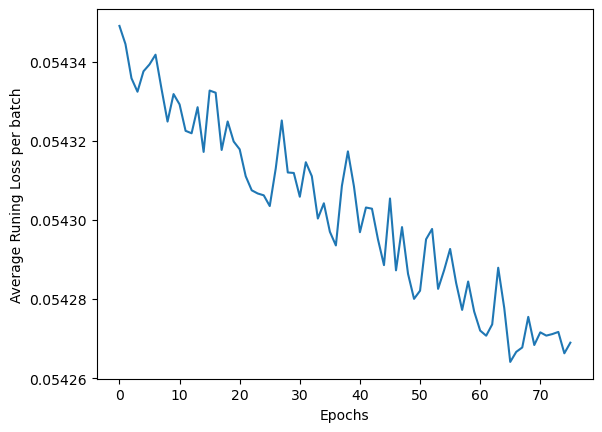

In [50]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [51]:
torch.save(final_model, 'model_100206_half_05.pt')